## Parsing EOS ".openjz" files

In [1]:
# imports
import pathlib, zipfile
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from stl import mesh

In [2]:
# some constants
test_file_path = (
    pathlib.Path().resolve().parent.parent / "CMU02_Adjusted_02-19-24.openjz"
)

unzipped_dir = test_file_path.parent/f"{test_file_path.stem}_extracted"

#### Start by extracting the openjz file to a directory of its contents

In [3]:
with zipfile.ZipFile(test_file_path, "r") as fp:
    fp.extractall(unzipped_dir)

#### Parse the "openjob" XML file

In [4]:
openjob_file_path = unzipped_dir / test_file_path.with_suffix(".openjob").name

tree = ET.parse(openjob_file_path)
root = tree.getroot()

target = root.find("target").text

print(
    f"Found an {root.tag} v{root.get('version')} file created by "
    f"{root.get('creator')} v{root.get('creator_version')} targeting {target}"
)

Found an openjob v1.4.4 file created by EOSPRINT v2.5.9.58707 targeting M291


In [5]:
# The paramset used
paramset = root.find("paramset")
material = paramset.find("materialname").text
thickness = paramset.find("materialthickness").text
print(
    f"ParamSet: {paramset.get('name')} (version {paramset.get('version')}) "
    f"for {thickness} thick {material}"
)

ParamSet: Ti64_PerformanceM291 1.10 (version 1.10) for 0.03 thick Ti64


In [6]:
# Whether absolutepositioning is set
absolute_positioning = root.find("absolutepositioning").get("enabled")=="true"
print(f"Positioning is {'NOT' if not absolute_positioning else ''} absolute")

Positioning is NOT absolute


In [7]:
# Getting all of the parts
parts = root.find("parts").findall("part")

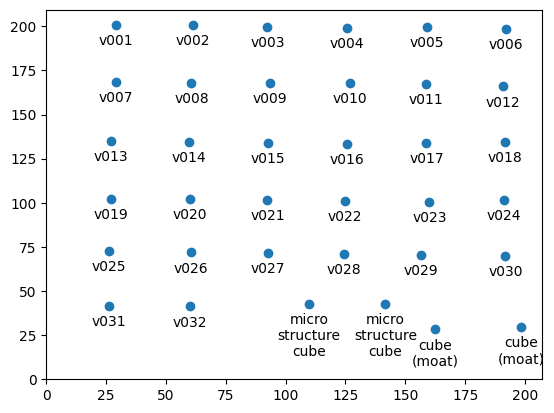

In [8]:
# Plotting the part locations
xlocs = [float(part.find("./translation/x").text) for part in parts]
ylocs = [float(part.find("./translation/y").text) for part in parts]
names = [part.get("file").split("\\")[-1][:-4] for part in parts]

f, ax = plt.subplots()
ax.scatter(xlocs,ylocs)
for x, y, name in zip(xlocs, ylocs, names):
    if name=="microstructure_cube_10x10x10mm":
        name = "micro\nstructure\ncube"
    elif name=="microstructure_cube_10x10x10mm_moat":
        name = "cube\n(moat)"
    ax.text(x, y-5, name, ha="center", va="top")
ax.set_xlim(0,ax.get_xlim()[1])
ax.set_ylim(0,ax.get_ylim()[1])
plt.show()

#### Visualize an STL file

v032.STL


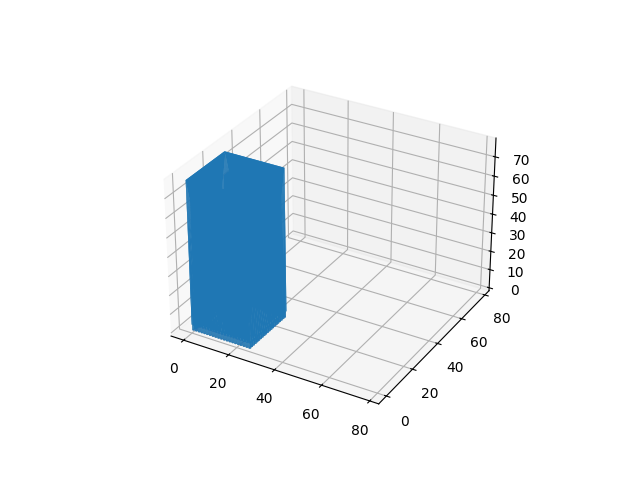

In [9]:
file_index = 5

filepath = unzipped_dir / parts[file_index].get("file").replace("\\","/")
print(filepath.name)

part_mesh = mesh.Mesh.from_file(filepath, mode="rb")

%matplotlib widget

f = plt.figure()
ax = f.add_subplot(projection="3d")
ax.add_collection(mplot3d.art3d.Poly3DCollection(part_mesh.vectors))
scale = part_mesh.points.flatten()
ax.auto_scale_xyz(scale, scale, scale)
plt.show()